# Jim's ADL demo

[This repository](https://github.com/jpivarski/analysis-description-language) contains an example language parsed by PLY (a lex-yacc implementation in Python) and interpreted as an abstract syntax tree. Its purpose is to show how these tools make short work of language design and testing— 3 days and less than 3000 lines of code— and also to illustrate the syntactical points I made on Monday and Tuesday with a working language. In principle, this example language is complete enough to test on a real analysis.

In our workshop, I think I got an idea of the problem you're solving: a generic programming language can express signal/control regions and systematic variations, but with too much flexibility— it hides the structure of the analysis. That's why you (both groups) introduced a block structure. However, when you want to compute complex physics objects and candidates formed by combinations of physics objects, the block structure gets unwieldy. I suggested that a functional expression-based syntax with arbitrarily deep nesting would simplify the handling of combinatorics.

The language that I'll be presenting here uses blocks for its control structure and functional expressions to handle physics objects and candidates. It's not unusual for a language to have two fundamentally different types of syntax structures: Python has expressions and statements, C++ has expressions, statements, templated type expressions, preprocessor instructions, and maybe more. Only a few very pure languages (LISP, Haskell, Scala, and Rust) are expression-only.

Although I wrote a fairly complete interpreter, it was written without performance in mind and is likely very slow. This is just to illustrate how the language ought to work; I have ideas about how this should be optimized (using [awkward-arrays](https://github.com/scikit-hep/awkward-array)). Interpreters are quick to write and therefore also quick to change in response to feedback. It does not perform a type-check and it operates on Python objects internally. Another implementation of the same language would use a different data representation.

In [1]:
%matplotlib inline
import numpy
import adl.interpreter

## Histogramming

First and foremost, it's a language for making histograms, or aggregating statistics in general. In the example below, the ADL is quoted in a string, made executable by `adl.interpreter.Run`. To run it, we call it and pass it some variables (only numbers `x` in this case).

In [2]:
run = adl.interpreter.Run("""
count "histogram" by
  regular(100, -5, 5) <- x
""")
run(x = numpy.random.normal(0, 1, 10000));

The `run` object is a container of histograms. We can find the histograms using the names provided in the code.

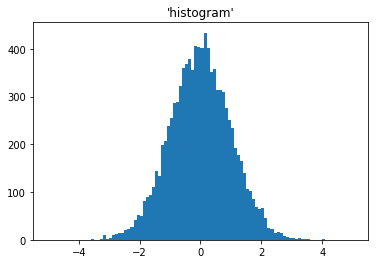

In [3]:
run["histogram"].plot()

Why `count` instead of `histogram`? The `count` primitive just says we want to count something; the binning clauses after `by` say how we want to divide it up. After all, histograms are just binned counting.

In [4]:
run = adl.interpreter.Run("""
count "one-bin histogram"
""")
run(x = numpy.random.normal(0, 1, 10000));

In [5]:
run["one-bin histogram"]

<Count 'one-bin histogram': 10000 +- 100.0>

In [6]:
run = adl.interpreter.Run("""
count "2D histogram" by
  regular(5, -5, 5)         <- x
  variable(-5, -1, 0, 1, 5) <- y
""")
run(x = numpy.random.normal(0, 1, 10000),
    y = numpy.random.normal(0, 1, 10000));

In [7]:
for i in range(-1, 6):
    for j in range(-1, 6):
        print(run["2D histogram", i, j])

<Count '2D histogram', 'underflow', 'underflow': 0 +- 0.0>
<Count '2D histogram', 'underflow', 0: 0 +- 0.0>
<Count '2D histogram', 'underflow', 1: 0 +- 0.0>
<Count '2D histogram', 'underflow', 2: 0 +- 0.0>
<Count '2D histogram', 'underflow', 3: 0 +- 0.0>
<Count '2D histogram', 'underflow', 'overflow': 0 +- 0.0>
<Count '2D histogram', 'underflow', 'overflow': 0 +- 0.0>
<Count '2D histogram', 0, 'underflow': 0 +- 0.0>
<Count '2D histogram', 0, 0: 0 +- 0.0>
<Count '2D histogram', 0, 1: 4 +- 2.0>
<Count '2D histogram', 0, 2: 3 +- 1.7320508075688772>
<Count '2D histogram', 0, 3: 3 +- 1.7320508075688772>
<Count '2D histogram', 0, 'overflow': 0 +- 0.0>
<Count '2D histogram', 0, 'overflow': 0 +- 0.0>
<Count '2D histogram', 1, 'underflow': 0 +- 0.0>
<Count '2D histogram', 1, 0: 261 +- 16.15549442140351>
<Count '2D histogram', 1, 1: 524 +- 22.891046284519195>
<Count '2D histogram', 1, 2: 568 +- 23.83275057562597>
<Count '2D histogram', 1, 3: 239 +- 15.459624833740307>
<Count '2D histogram', 1, '

There's no fundamental distinction between 1D, 2D, or nD histograms; they're all just 1D histograms of 1D histograms— a block of grid values to be sliced and projected. Several histogramming packages are moving this way (such as [histbook](https://github.com/scikit-hep/histbook), [Boost.Histogram](https://github.com/HDembinski/histogram), and [ROOT 7](https://root.cern.ch/root-7)).

Here's a slice: bin 3 of the first axis is a 1D histogram (with variable-sized binning; see the code).

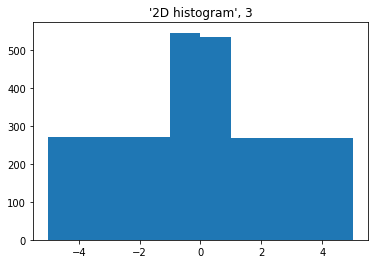

In [8]:
run["2D histogram", 3].plot()

An analysis includes many histograms, so an ADL source file would contain many such `count` statements and the resulting object would hold them all together in an organized way. (This could simplify the configuration of many-histogram fitters like HistFactory or Combiner.)

In [9]:
run = adl.interpreter.Run("""
count "first" by
  regular(100, -5, 5) <- x

count "second" by
  regular(100, 0, 5) <- x**2
""")
run(x = numpy.random.normal(0, 1, 10000));

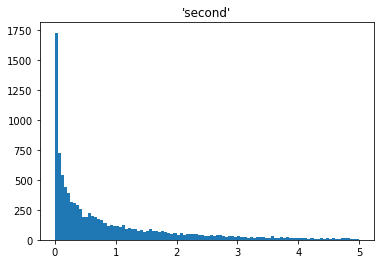

In [10]:
run["second"].plot()

## Other statistical aggregations

For other types of aggregations, `count` can be replaced by `sum`, `profile`, or `fraction`.

In [11]:
run = adl.interpreter.Run("""
count    "first"       # no quantity
sum      "second" x    # add up x
profile  "third"  x    # compute mean and variance of x
fraction "fourth" p    # compute fraction for which p is true
""")
run(x = [1, 2, 3, 4, 5], p = [False, False, True, True, False]);

In [12]:
run["first"]

<Count 'first': 5 +- 2.23606797749979>

In [13]:
run["second"]

<Sum 'second': 15.0>

In [14]:
run["third"]

<Profile 'third': 3.0 +- 0.6324555320336759>

In [15]:
run["fourth"]

<Fraction 'fourth': 0.4 +- 0.4680694638641432>

In [16]:
run["fourth"].error(method="wilson")

0.7857225398615839

Of course, they can all be weighted.

In [17]:
run = adl.interpreter.Run("""
count "histogram" by
  regular(100, -5, 5) <- x
  weight x**2
""")
run(x = numpy.random.normal(0, 1, 10000));

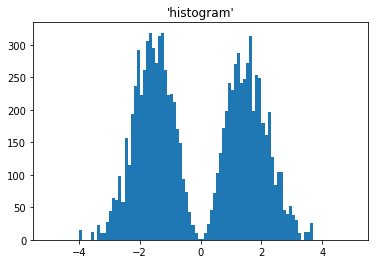

In [18]:
run["histogram"].plot()

## Signal and control regions

So far what we've seen could almost be done with a standard histogramming package. The reason we want a language is to simplify the organization of many control regions and systematic variations. To define groups of event selections, use the `region` keyword.

In [19]:
x = numpy.random.normal(0, 1, 10000)
y = x + numpy.random.normal(0, 0.1, 10000)

run = adl.interpreter.Run("""
region "signal": x >= 0          # may be a complex predicate with and, or, not
{
  count "histogram" by
    regular(100, -5, 5) <- y
}

region "control": x < 0
{
  count "histogram" by
    regular(100, -5, 5) <- y
}
""")
run(x = x, y = y);

The histograms are nested within each region.

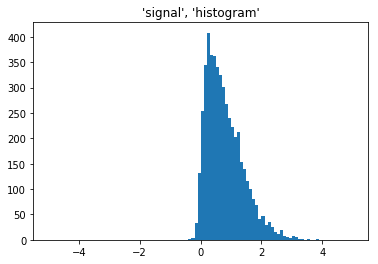

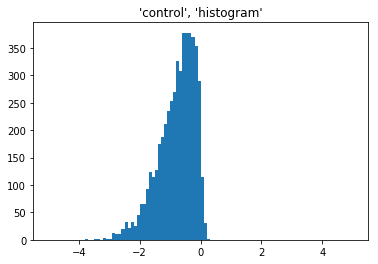

In [20]:
run["signal", "histogram"].plot()
run["control", "histogram"].plot()

The above example (and a lot of physics analyses!) involves dangerous duplication: we want to see the same histograms in all regions to compare them, but the names, binning, and fill expressions have to be kept the same by hand. To fix this problem, the `region` keyword can take multiple named predicates.

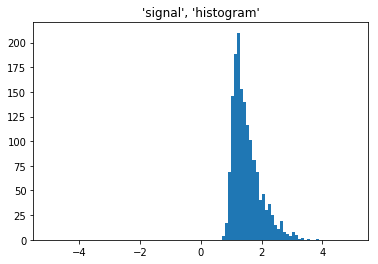

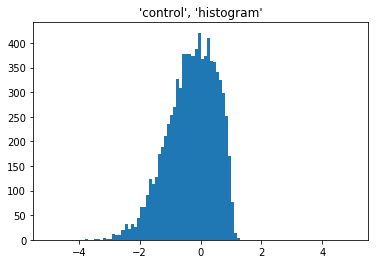

In [21]:
run = adl.interpreter.Run("""
region
  "signal": x >= 1      # must be separated by newlines or semicolons
  "control": x < 1
{
  count "histogram" by
    regular(100, -5, 5) <- y
}
""")
run(x = x, y = y);

run["signal", "histogram"].plot()
run["control", "histogram"].plot()

Now imagine an analysis with a dozens of regions and hundreds of histograms in each. We only need to write the histogram parameters once (as above) inside a `region` with all the predicates listed. If we change a histogram, we don't have to change its partners in a dozen different places.

If the regions represent non-overlapping rectangles, like the bins of a histogram, then we can use the same axis syntax to generate them. This avoids copy-paste errors in the predicates themselves.

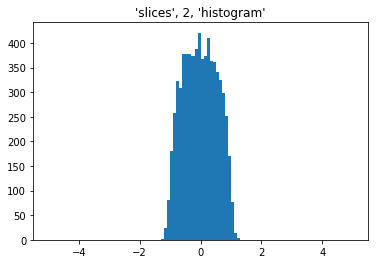

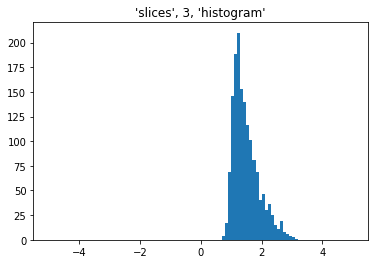

In [22]:
run = adl.interpreter.Run("""
region "slices": true by      # predicate is "true" because all subdivision happens in the binning
  regular(5, -5, 5) <- x
{
  count "histogram" by
    regular(100, -5, 5) <- y
}
""")
run(x = x, y = y);

run["slices", 2, "histogram"].plot()
run["slices", 3, "histogram"].plot()

Now that we're defining rectangular regions and the bins of histograms using the same mechanism and extracting them using the same mechanism: strings for named regions and integers for sequential slices.

In [23]:
run["slices", 3, "histogram", 75]

<Count 'slices', 3, 'histogram', 75: 11 +- 3.3166247903554>

And of course, `regions` can be nested. A particularly complex analysis might need that. (This also is the reason for the curly brackets, to make the structure clear.)

In [24]:
run = adl.interpreter.Run("""
region "slices": true by
  regular(5, -5, 5) <- x
{
  region "one":   y > -3
         "two":   y >  0
         "three": y >  3
  {
    count "counter"
  }
}
""")
run(x = x, y = y);

for i in range(-1, 6):
    for j in "one", "two", "three":
        print(run["slices", i, j, "counter"])

<Count 'slices', 'underflow', 'one', 'counter': 0 +- 0.0>
<Count 'slices', 'underflow', 'two', 'counter': 0 +- 0.0>
<Count 'slices', 'underflow', 'three', 'counter': 0 +- 0.0>
<Count 'slices', 0, 'one', 'counter': 1 +- 1.0>
<Count 'slices', 0, 'two', 'counter': 0 +- 0.0>
<Count 'slices', 0, 'three', 'counter': 0 +- 0.0>
<Count 'slices', 1, 'one', 'counter': 1592 +- 39.89987468652001>
<Count 'slices', 1, 'two', 'counter': 0 +- 0.0>
<Count 'slices', 1, 'three', 'counter': 0 +- 0.0>
<Count 'slices', 2, 'one', 'counter': 6845 +- 82.73451516749222>
<Count 'slices', 2, 'two', 'counter': 3355 +- 57.92236183029832>
<Count 'slices', 2, 'three', 'counter': 0 +- 0.0>
<Count 'slices', 3, 'one', 'counter': 1538 +- 39.21734310225516>
<Count 'slices', 3, 'two', 'counter': 1538 +- 39.21734310225516>
<Count 'slices', 3, 'three', 'counter': 4 +- 2.0>
<Count 'slices', 4, 'one', 'counter': 14 +- 3.7416573867739413>
<Count 'slices', 4, 'two', 'counter': 14 +- 3.7416573867739413>
<Count 'slices', 4, 'three'

## Systematic variations

Another aspect of physics analysis that often involves code duplication is varying quantities to gauge systematic errors. We want those in some auto-duplicating structure as well.

The `vary` block defines sets of named parameters, which can be placed inside of `regions` or may contain `regions`.

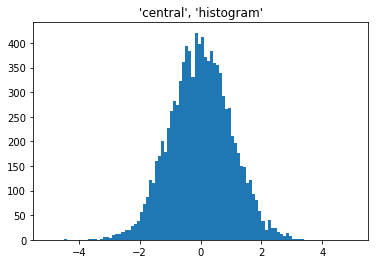

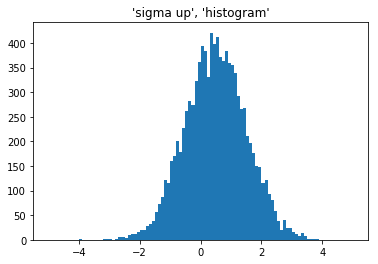

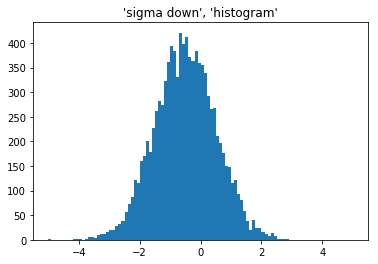

In [25]:
run = adl.interpreter.Run("""
vary
  "central":    epsilon :=  0       # assignments use := for clarity
  "sigma up":   epsilon :=  0.5
  "sigma down": epsilon := -0.5
{
  count "histogram" by
    regular(100, -5, 5) <- x + epsilon
}
""")
run(x = numpy.random.normal(0, 1, 10000));

run["central", "histogram"].plot()
run["sigma up", "histogram"].plot()
run["sigma down", "histogram"].plot()

## Selecting by source

Often the data and Monte Carlo samples representing distinct signal and background processes are in different files. We'll need to run the analysis code over each sample separately, but we'd like to use the same analysis definition to avoid copy-paste errors. However, quantities that are important to track in some samples— like comparisons to "truth" in Monte Carlo samples— can't even be calculated in others— like the real data.

The `source` block allows us to filter by source name; regions and statistical collectors that aren't relevant for a given source aren't even allocated.

In [26]:
run = adl.interpreter.Run("""
source "data-*"         # accepts wildcards (POSIX glob pattern)
{
  count "only data"
}

not source "data-*"
{
  count "only MC"
}

count "both"
""")
run("data-123", x = [1, 2, 3]);
run("mc-12345", x = [1, 2, 3, 4, 5]);

In [27]:
run["only data"]

<Count 'only data': 3 +- 1.7320508075688772>

In [28]:
run["only MC"]

<Count 'only MC': 5 +- 2.23606797749979>

In [29]:
run["both"]

<Count 'both': 8 +- 2.8284271247461903>

## Counting non-scalar quantities

Until now, we've been using streams of numbers for testing. A real analysis operates on objects and nested lists of objects, which we'll be focusing on in the discussion of expression syntax in the following sections. However, there is one block structure concerned with list structure: the `for` loop.

Despite what I said about implicit loops being okay for analysis (and some expressions will perform implicit loops in their calculations), the statistical counters should be explicit about whether they're counting objects or objects within objects. I wouldn't want a student to be struggling with why their histograms add up to different totals, only to discover that some minor syntactic point initiated an implicit loop around their counter.

Therefore, loops _that can contain statistical counters_ must be in an explicit loop.

In [30]:
run = adl.interpreter.Run("""
count "per object"

for item in x              # can "zip" together equal-sized lists with item1 in x1 ; item2 in x2 ; ...
{
  count "per item"
}
""")
run(x = [[1, 2, 3], [], [4, 5]]);

In [31]:
run["per object"]

<Count 'per object': 3 +- 1.7320508075688772>

In [32]:
run["per item"]

<Count 'per item': 5 +- 2.23606797749979>

## Assignment: defining quantities and functions

Now we're moving from the block syntax to a discussion of expressions. Whereas the block syntax is special-purpose to the task of making organized collections of histograms, the expression syntax is conventional. My goal was to invent as little as possible, taking the simplest and most common syntax from popular languages. While physicists are supposed to focus on the logic of defining signal and control regions for their analysis, the expression syntax should come naturally— it should not be the subject of focus.

However, Gokhan brought up the point (which I highly agree with) that using a single `=` for assignment is bad form. Assignment is different from equality; in particular, it's asymmetric (the thing on the left gets defined, the thing on the right is its definition). Although `=` for assignment is widespread, following FORTRAN, there's another tradition (from ALGOL to Pascal to XQuery) of using `:=`.

As it stands, this ADL has no `=` operator at all (it's always a syntax error); one can only use `:=` for assignment or `==` for equality checking. This is easy to change.

In [33]:
run = adl.interpreter.Run("""

y := x * 10

""")
run(x = [1, 2, 3])

{'x': [1, 2, 3], 'y': [10, 20, 30]}

Until now, we've been hiding the output of calling `run`, showing only the histograms it contains after execution. It's an implementation-specific choice, but this implementation returns the input quantities and all values assigned at the highest scope. That makes these analysis scripts _chainable—_ you can pass the output of one into the input of the next.

I mentioned scope: when a symbol is defined, it can be used in that level of curly brackets or any nested levels, but not outside of the curly brackets in which it's defined. This is exactly like C.

Unlike C and Python, functions are defined "the same way." That is, you put the function name and parameters on the left of the `:=` and its intended value on the right. This is a popular convention among functional languages (ML/OCaml, Haskell, F#, Scala, Elm) and languages intended for doing mathematics (Julia, Mathematica, Maxima, Prolog) because it looks like math.

In [34]:
run = adl.interpreter.Run("""

f(z) := z * 10

y := f(x)

""")
run(x = [1, 2, 3])

{'x': [1, 2, 3], 'y': [10, 20, 30]}

Longer functions can be written as a sequence of assignments ending in an expression, as long as they're wrapped in curly brackets (which also limits the scope of temporary variables defined in the function).

In [35]:
run = adl.interpreter.Run("""

f(z) := {
  q := z**2         # non-last statement must be an assignment
  q + 1             # last statement must be an expression; the return value
}

y := f(x)

""")
run(x = [1, 2, 3])

{'x': [1, 2, 3], 'y': [2, 5, 10]}

What if we tried to use a temporary variable outside of its scope? We'll get an error, of course. Since this language is built up from a lex-yacc parser, tracking line numbers at each step, the error messages are useful. (Only potential issue with this implementation: the line number is the line number in the ADL source file, not the Python source file, so a search in a text editor may be confusing. The line is quoted with an arrow under the error, though.)

In [36]:
run = adl.interpreter.Run("""

f(z) := {
  q := z**2
  q + 1
}

y := f(x) + q

""")

try:
    run(x = [1, 2, 3])
except Exception as err:
    print(err)

Line 8: no symbol named 'q' in this scope
    y := f(x) + q
----------------^


## Expression syntax

For the expressions themselves, I decided to be very conventional: they are identical to Python. When building up a data analysis, the last thing on the analyst's mind is syntax. We have no reason to invent anything new— we just have to embed a familiar-enough syntax into our block language.

It could as easily have been C syntax, but Python has a few niceties.

In [37]:
run = adl.interpreter.Run("""

y := (30 <= x < 40)      # means (30 <= x) and (x < 40)

""")
run(x = [20, 25, 30, 35, 40, 45])

{'x': [20, 25, 30, 35, 40, 45], 'y': [False, False, True, True, False, False]}

And of course the order of operations is right (from loosest to tightest):

   * commas in function arguments
   * logical or
   * logical and
   * logical not
   * comparisons (equality and inequalities), including the implicit "and" when comparisons are chained
   * binary plus and minus (between two values)
   * times, divide, and modulo
   * unary plus and minus (before a value)
   * exponentiation, for which I have chosen Python's and FORTRAN's `**` instead of `^`
   * parenthesized expressions

In [38]:
run = adl.interpreter.Run("""

y := 10 + x * 2

""")
run(x = [1, 2, 3, 4, 5])

{'x': [1, 2, 3, 4, 5], 'y': [12, 14, 16, 18, 20]}

## Builtin functions

We talked about what should be the starter set of math functions and how we would go about choosing that. Months ago, [I had a conversation](https://github.com/pydata/numexpr/issues/304) with the author of NumExpr about exactly this, so I looked it up and based a first implementation on what we'd agreed on.

**Basic math:** sqrt, exp, exp2, log, log2, log10, sin, cos, tan, arcsin, arccos, arctan, arctan2, hypot, rad2deg, deg2rad, sinh, cosh, tanh, arcsinh, arccosh, arctanh

**Special functions:** erf, erfc, factorial, gamma, lgamma

**Rounding and discontinuous:** abs, round, floor, ceil, sign, heaviside

**Fast calculations of common combinations:** expm1, log1p, ldexp, logaddexp, logaddexp2

**Number type:** isfinite, isinf, isnan

**Bit-level detail:** nextafter, nextbefore, nexttoward

In [39]:
run = adl.interpreter.Run("""

y := sqrt(x)

""")
run(x = [1, 2, 3, 4, 5])

{'x': [1, 2, 3, 4, 5],
 'y': [1.0, 1.4142135623730951, 1.7320508075688772, 2.0, 2.23606797749979]}

## Domain-specific types: Lorentz vectors

More relevant are the functions that operate on physics objects representing particles. The conventional way to access data from an object is to put a dot and the name of that property after the object. As discussed in the workshop, these don't have to be literal values in memory— they may be generated from available data on demand. There is no reason to distinguish values in memory from zero-argument member functions with parentheses: `particle.pt()` vs `particle.pt`.

Separation of data presentation and in-memory representation is the defining characteristic of a high-level language. Some high-level languages, like Python, let you choose which properties to access without parentheses when you're defining the class. Other high-level languages, like Scala, let you choose whether to add the parentheses when you're _accessing_ the data. They really are superfluous.

In [40]:
run = adl.interpreter.Run("""

out := particle.pt

""")

particle = [{"px": 1, "py": 2, "pz": 3, "energy": 4, "charge":  1},    # cartesian: calculate pt
            {"pt": 1, "eta": 2, "phi": 3, "mass": 4, "charge": -1},    # cylindrical: return pt
            {"pt": 1, "eta": 2, "phi": 3, "mass": 4}]                  # only kinematics matter

run(particle = particle)["out"]

[2.23606797749979, 1, 1]

In [41]:
try:
    run(particle = [{"px": 1}])                                        # but you must at least have kinematics
except Exception as err:
    print(err)

Line 3: function raised AttributeError: 'dict' object has no attribute 'pt'
    out := particle.pt
-------------------^


Although this was implemented in a dynamicly typed function (and this ADL interpreter is dynamically typed as well), the same effect can be achieved in a statically typed language with [structural typing](https://en.wikipedia.org/wiki/Structural_type_system). We need to define a _protocol_ for dealing with Lorentz vectors, but not an explicit representation.

## Structure manipulations

You may have noticed that I made no mention of "physics objects" in the block structure of the language. It was purely for defining how events fill histograms (or sub-event structures, using the `for` loop). That's because the structure manipulations for making and refining particle candidates can be expressed with functional programming.

For example, suppose we want to combine muons into Z candidates.

In [42]:
muons = [[{'px': -52.89946, 'py': -11.65467, 'pz': -8.16079, 'energy': 54.7795},
          {'px': 37.73778, 'py': 0.69347, 'pz': -11.30758, 'energy': 39.4017}],
         [{'px': -0.81646, 'py': -24.40426, 'pz': 20.19997, 'energy': 31.69044}],
         [{'px': 48.98783, 'py': -21.72314, 'pz': 11.16829, 'energy': 54.73979},
          {'px': 0.82757, 'py': 29.80051, 'pz': 36.96519, 'energy': 47.48886}],
         [{'px': 22.08833, 'py': -85.83546, 'pz': 403.84845, 'energy': 413.46002},
          {'px': 76.69192, 'py': -13.95649, 'pz': 335.09421, 'energy': 344.04153}],
         [{'px': 45.17132, 'py': 67.24879, 'pz': -89.69573, 'energy': 120.86432},
          {'px': 39.75096, 'py': 25.40367, 'pz': 20.11505, 'energy': 51.28461}],
         [{'px': 9.22811, 'py': 40.55438, 'pz': -14.64216, 'energy': 44.09331},
          {'px': -5.79372, 'py': -30.29519, 'pz': 42.95438, 'energy': 52.88152}],
         [{'px': 12.53872, 'py': -42.54871, 'pz': -124.44899, 'energy': 132.11803},
          {'px': 29.54184, 'py': -4.44552, 'pz': -26.35655, 'energy': 39.8392}],
         [{'px': 34.88376, 'py': -15.98272, 'pz': 155.53117, 'energy': 160.19452}],
         [{'px': -53.16697, 'py': 92.02971, 'pz': 35.63884, 'energy': 112.09965},
          {'px': 11.49187, 'py': -4.41739, 'pz': -17.47379, 'energy': 21.37571}],
         [{'px': -67.01485, 'py': 53.15917, 'pz': 54.41294, 'energy': 101.37883},
          {'px': -18.11876, 'py': -35.10617, 'pz': 58.0369, 'energy': 70.20702}],
         [{'px': 15.98303, 'py': 49.11392, 'pz': 118.14836, 'energy': 128.94449},
          {'px': 34.68441, 'py': -30.96738, 'pz': 193.67882, 'energy': 199.18204}],
         [{'px': -70.51191, 'py': -27.018, 'pz': -15.32515, 'energy': 77.05046},
          {'px': -38.02874, 'py': 33.25009, 'pz': -70.31803, 'energy': 86.5817}],
         [{'px': 58.94381, 'py': 53.77843, 'pz': 38.63808, 'energy': 88.65329}],
         [{'px': -15.58787, 'py': -21.09038, 'pz': -2.22933, 'energy': 26.32047}],
         [{'px': -122.33012, 'py': 37.77131, 'pz': -215.75999, 'energy': 250.88586},
          {'px': -1.05975, 'py': 49.60892, 'pz': -69.04716, 'energy': 85.02759}],
         [{'px': -46.70415, 'py': -28.66672, 'pz': 8.28177, 'energy': 55.42253},
          {'px': 39.02002, 'py': 18.71108, 'pz': -13.49476, 'energy': 45.32976}],
         [{'px': 51.29466, 'py': -16.85857, 'pz': 47.35022, 'energy': 71.81509},
          {'px': 17.45092, 'py': 25.66767, 'pz': -29.31544, 'energy': 42.69391}],
         [{'px': 43.2812, 'py': -17.84495, 'pz': -119.52125, 'energy': 128.36295}],
         [{'px': -45.92393, 'py': 15.23271, 'pz': -14.82476, 'energy': 50.60462},
          {'px': 22.54977, 'py': -3.65716, 'pz': -86.19814, 'energy': 89.17397}],
         [{'px': 43.29361, 'py': 25.70282, 'pz': 96.64295, 'energy': 108.97176},
          {'px': -33.28158, 'py': 6.87535, 'pz': 14.86385, 'energy': 37.09285},
          {'px': -4.37619, 'py': -19.02892, 'pz': -34.15688, 'energy': 39.34405}],
         [{'px': -27.43815, 'py': -52.50413, 'pz': -38.53326, 'energy': 70.67078},
          {'px': 28.94416, 'py': 11.22752, 'pz': 15.83478, 'energy': 34.85073}],
         [{'px': -24.2005, 'py': 31.07205, 'pz': 12.58766, 'energy': 41.34727},
          {'px': 26.48993, 'py': 13.59609, 'pz': 138.76196, 'energy': 141.92062}],
         [{'px': 41.23143, 'py': 30.71335, 'pz': -92.04125, 'energy': 105.42744},
          {'px': -39.87832, 'py': -4.66021, 'pz': -48.14925, 'energy': 62.69258}],
         [{'px': -29.21921, 'py': -47.15208, 'pz': -43.85278, 'energy': 70.71179}],
         [{'px': -61.25238, 'py': -13.57999, 'pz': -104.55434, 'energy': 121.93396}],
         [{'px': 7.96841, 'py': 51.32637, 'pz': -82.80624, 'energy': 97.74854},
          {'px': -15.082, 'py': -31.8766, 'pz': -9.57083, 'energy': 36.54034}],
         [{'px': 8.99396, 'py': -24.18176, 'pz': -48.57234, 'energy': 54.99938}],
         [{'px': -28.64058, 'py': 41.36348, 'pz': -54.63372, 'energy': 74.27028}],
         [{'px': 22.6369, 'py': -66.99755, 'pz': -53.38839, 'energy': 88.60831},
          {'px': -28.2125, 'py': 4.61466, 'pz': 9.84851, 'energy': 30.23648}],
         [{'px': 59.9748, 'py': 38.37789, 'pz': -202.81454, 'energy': 214.9502},
          {'px': -46.90805, 'py': -7.24472, 'pz': -35.08104, 'energy': 59.02154}]]

The following computes (and histograms) _all_ of the candidates, using only distinct pairs of muons. We see that from semi-implicit loops over candidates (the `map` functional is not really implicit, just succinct) and the explicit loop over the histogram filler. As I said above, it's more important to be explicit about loops if there is mutable state (an increasing counter) at stake.

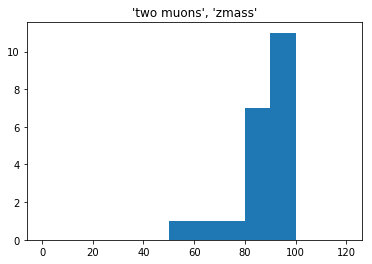

In [44]:
run = adl.interpreter.Run("""
region "two muons": muons.size >= 2
{

  zmasses := muons.distincts.map(pair => (pair[0] + pair[1]).mass)

  for zmass in zmasses
  {
    count "zmass" by
      regular(12, 0, 120) <- zmass
  }

}
""")
run(muons = muons)
run["two muons", "zmass"].plot()

In [46]:
run = adl.interpreter.Run("""
region "two muons": muons.size >= 2
{

  zmass := muons.distincts
                .map(pair => (pair[0] + pair[1]))
                .maxby(zcandidate => zcandidate.pt)
                .map(zcandidate => zcandidate.mass)
                .flatten

  count "zmass" by
    regular(12, 0, 120) <- zmass

}
""")
run(muons = muons)
run["two muons", "zmass"].plot()

ADLRuntimeError: Line 9: function raised TypeError: 'float' object is not iterable
                    .flatten
--------------------^